In [1]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO

In [2]:
import torch
pytorch_version = "torch-" + torch.__version__ + ".html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 10.2 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 8.9 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 7.0 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 8.4 MB/s 
     |████████████████████████████████| 407 kB 8.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=77d650e8ddbfc93da398fab57b3e6a6d7aa5ab5ad9565c73e315d2af107d8d2a
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [3]:
!pip install deepchem
import deepchem as dc

     |████████████████████████████████| 608 kB 8.2 MB/s 
     |████████████████████████████████| 22.5 MB 1.2 MB/s 


In [4]:
import pandas as pd
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import rdmolops, Draw
import os

In [5]:
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [6]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ')
Sample  nodes:  32
Sample  edges:  68


In [7]:
# # This code only needs to be run once

# # source of data: http://moleculenet.ai/datasets-1
# smile_path = 'drive/MyDrive/Graph_Data_2/raw/'
# smile_name = 'ESOL.csv'

# smile = pd.read_csv(os.path.join(smile_path, smile_name))
# smile.head()

In [8]:
# smile.shape

In [9]:
# smile.drop(labels=['num', 'name'], axis=1, inplace=True)
# print(smile.shape)
# print(smile['p_np'].value_counts())

In [10]:
# count = 0
# for index, row in smile.iterrows():
#   molecule = Chem.MolFromSmiles(row["smiles"])
#   if molecule is None:
#     smile = smile.drop([index])
#     count+= 1

# print(count)


In [11]:
# print(smile.shape)
# print(smile['p_np'].value_counts())

In [12]:
# smile.to_csv('drive/MyDrive/Graph_Data/raw/BBBP_P.csv', encoding='utf-8', index=False)

In [13]:
print('Edge indexes in coo format: ', data[0].edge_index.t()) #edge indexes in coo format
print('\n Node features: ', data[0].x) #node features matrix
print('\n Edge features: ', data[0].edge_attr) #edge features matrix
print('\n Label: ', data[0].y) # label

Edge indexes in coo format:  tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],

In [14]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GATv2Conv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 256

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        torch.manual_seed(42)

        self.initial_conv = GATv2Conv(data.num_features, embedding_size)
        self.conv1 = GATv2Conv(embedding_size, embedding_size)
        self.conv2 = GATv2Conv(embedding_size, embedding_size)
        self.conv3 = GATv2Conv(embedding_size, embedding_size)
        self.conv4 = GATv2Conv(embedding_size, embedding_size)


        self.linear1 = Linear(embedding_size*2, embedding_size)
        self.linear2 = Linear(embedding_size, 1)

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv4(hidden, edge_index)
        hidden = F.relu(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Output 
        hidden = self.linear1(hidden).relu()
        hidden = F.dropout(hidden, p=0.2, training=self.training)
        hidden = self.linear2(hidden)

        return hidden, hidden

In [15]:
model = GAT()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GAT(
  (initial_conv): GATv2Conv(9, 256, heads=1)
  (conv1): GATv2Conv(256, 256, heads=1)
  (conv2): GATv2Conv(256, 256, heads=1)
  (conv3): GATv2Conv(256, 256, heads=1)
  (conv4): GATv2Conv(256, 256, heads=1)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)
Number of parameters:  665601


In [16]:
from torch_geometric.data import DataLoader
# import warning
# warnings.filterwarnings("ignore")

In [17]:
# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

In [18]:
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
# #Data split
train_percent = 0.8
validate_percent = 0.1
train_index = int(train_percent*len(data))
valid_index = int(validate_percent*len(data))

data = data.shuffle()
train_dataset = data[:train_index]
valid_dataset = data[train_index:(train_index+valid_index)]
test_dataset = data[(train_index+valid_index):]

print('Length of train dataset: ', len(train_dataset))
print('Length of validation dataset: ', len(valid_dataset))
print('Length of test dataset: ', len(test_dataset))

Length of train dataset:  902
Length of validation dataset:  112
Length of test dataset:  114


In [20]:
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 128

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(epoch):
    for batch in train_loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      loss = torch.sqrt(loss_fn(pred, batch.y.float()))       
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

def valid(epoch):
  for batch in valid_loader:
    batch.to(device)
    optimizer.zero_grad() 
    # Passing the node features and the connection info
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
    loss = torch.sqrt(loss_fn(pred, batch.y.float()))  # could get rid of sqrt     
    loss.backward()  
    # Update using the gradients
    optimizer.step()   
  return loss, embedding

print("Starting training...")
losses = []
losses_valid = []
for epoch in range(2000):
    model.train()
    loss, h = train(epoch=epoch)
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

    model.eval()
    if epoch % 5 == 0:
      loss, h = valid(epoch=epoch)
      loss = loss.detach().cpu().numpy()
      losses_valid.append(loss)
      if epoch % 100 == 0:
        print(f"Epoch {epoch} | Valid Loss {loss}")

print("Done")

Starting training...


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0 | Train Loss 2.1259021759033203
Epoch 0 | Valid Loss 1.9285401105880737
Epoch 100 | Train Loss 1.259706974029541
Epoch 100 | Valid Loss 1.012258768081665
Epoch 200 | Train Loss 0.39738166332244873
Epoch 200 | Valid Loss 0.8322829604148865
Epoch 300 | Train Loss 0.5203909873962402
Epoch 300 | Valid Loss 0.680942714214325
Epoch 400 | Train Loss 0.571142315864563
Epoch 400 | Valid Loss 0.6351013779640198
Epoch 500 | Train Loss 0.30268898606300354
Epoch 500 | Valid Loss 0.5949371457099915
Epoch 600 | Train Loss 0.38657650351524353
Epoch 600 | Valid Loss 0.5728828310966492
Epoch 700 | Train Loss 0.3334839940071106
Epoch 700 | Valid Loss 0.6351468563079834
Epoch 800 | Train Loss 0.5584441423416138
Epoch 800 | Valid Loss 0.501396656036377
Epoch 900 | Train Loss 0.27208444476127625
Epoch 900 | Valid Loss 0.5855982899665833
Epoch 1000 | Train Loss 0.5091040134429932
Epoch 1000 | Valid Loss 0.47635915875434875
Epoch 1100 | Train Loss 0.5107163786888123
Epoch 1100 | Valid Loss 0.470264583

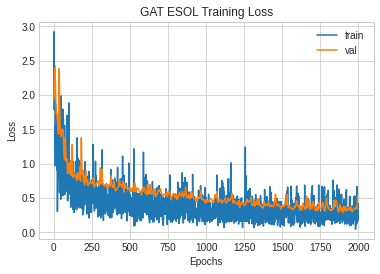

In [21]:
import seaborn as sns
losses_float = [float(loss) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses)] 

losses_valid_float = [float(loss) for loss in losses_valid] 
loss_indices_valid = [i for i,l in enumerate(losses_valid)] 

loss_indices_valid = [x * 5 for x in loss_indices_valid]

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

plt.plot(loss_indices, losses_float, label='train');
plt.plot(loss_indices_valid, losses_valid_float, label='val')
plt.title("GAT ESOL Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.show()

In [22]:
import pandas as pd 


df = pd.DataFrame()
column_names = ["y_real", "y_pred"]
df = pd.DataFrame(columns = column_names)

for test_batch in test_loader:
  with torch.no_grad():
      test_batch.to(device)
      pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
      out = (pred).float()

      xtra = {"y_real": test_batch.y.tolist(),"y_pred": out.tolist()}
      df = df.append(pd.DataFrame(xtra))
      

      # df["y_real"] = test_batch.y.tolist()
      
      # df["y_pred"] = out.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df



,y_real,y_pred
0,-2.530,-2.738697
1,-6.960,-6.247654
2,-2.090,-1.918417
3,-0.430,-0.630561
4,-0.600,-1.084456
...,...,...
109,-4.640,-2.521825
110,-0.500,-0.759842
111,-2.740,-2.139674
112,-2.000,-1.872251


In [23]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(df["y_real"], df["y_pred"], squared = False))

0.6520225338030302


In [25]:
import pandas as pd 


df = pd.DataFrame()
column_names = ["y_real", "y_pred"]
df = pd.DataFrame(columns = column_names)

for test_batch in train_loader:
  with torch.no_grad():
      test_batch.to(device)
      pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
      out = (pred).float()

      xtra = {"y_real": test_batch.y.tolist(),"y_pred": out.tolist()}
      df = df.append(pd.DataFrame(xtra))
      

      # df["y_real"] = test_batch.y.tolist()
      
      # df["y_pred"] = out.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df


,y_real,y_pred
0,-0.800,-0.496657
1,-2.980,-2.801650
2,-2.460,-1.915947
3,-5.050,-4.818815
4,-2.240,-2.498305
...,...,...
1,-0.854,-0.769155
2,-1.710,-2.045449
3,-2.380,-2.461201
4,-0.700,-0.899107


In [26]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(df["y_real"], df["y_pred"], squared = False))

0.3130286494037308


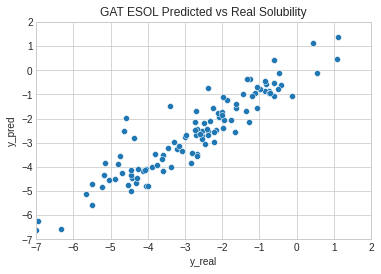

In [24]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt.set_title("GAT ESOL Predicted vs Real Solubility")
plt